# Cox-Time

In this notebook we will train the [Cox-Time method](http://jmlr.org/papers/volume20/18-424/18-424.pdf).
We will use the METABRIC data sets as an example

A more detailed introduction to the `pycox` package can be found in [this notebook](https://nbviewer.jupyter.org/github/havakv/pycox/blob/master/examples/01_introduction.ipynb) about the `LogisticHazard` method.

The main benefit Cox-Time (and the other Cox methods) has over Logistic-Hazard is that it is a continuous-time method, meaning we do not need to discretize the time scale.

In [1]:
! pip install sklearn-pandas
! pip install seaborn
! pip install imbalanced-learn
! pip install lifelines
! pip install pycox

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 349.3/349.3 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.7/115.7 kB 4.1 MB/s eta 0:00:00
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4031 sha256=2eab39e1e1f9b04eee28f80a8289411e0e5bfbacb03f98aff7f5b0c12c19a6aa
  Stored in directory: /root/.cache/pip/wheels/25/cc/e0/ef2969164144c899fedb22b338f6703e2b9cf46eeebf254991
Successfully built autograd-gamma
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.6/73.6 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.9/67.9 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.9/41.9 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 30.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.3/93.3 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 kB 2.4 MB

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from lifelines.utils import concordance_index

from sklearn.preprocessing import StandardScaler
from sklearn_pandas import DataFrameMapper 

from sklearn.model_selection import KFold
from pycox.preprocessing.label_transforms import LabTransDiscreteTime
import pickle

import torch.nn as nn
from sklearn.utils import resample
import shutil


In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn_pandas import DataFrameMapper

import torch
import torchtuples as tt

from pycox.datasets import metabric
from pycox.models import CoxTime
from pycox.models.cox_time import MLPVanillaCoxTime
from pycox.evaluation import EvalSurv

In [4]:
## Uncomment to install `sklearn-pandas`
! pip install sklearn-pandas

In [5]:
np.random.seed(1234)
_ = torch.manual_seed(123)

## Dataset

We load the METABRIC data set and split in train, test and validation.

In [6]:
# # Paths to your folders
# training_folder = '/kaggle/input/time-to-accident-dataset-2/gog_features/gog_features'
# toas_folder = '/kaggle/input/time-to-accident-dataset-2/toas'

# # Feature keys
# feature_keys = ['frame_embeddings', 'object_level_features', 'graph_embeddings']
# FPS = 10

# # Output directory for storing combined files
# output_directory = 'combined_frames'
# if not os.path.exists(output_directory):
#     os.makedirs(output_directory)

# def process_folder(folder_name):
#     # Dictionary to hold combined frame data by frame_id
#     combined_frame_data = {i: [] for i in range(1, 51)}  # Assuming 50 frames per video

#     for npz_file in os.listdir(folder_name):
#         if npz_file.endswith('.npz'):
#             file_id = os.path.splitext(npz_file)[0]
#             npz_path = os.path.join(folder_name, npz_file)

#             npz_data = np.load(npz_path)

#             if all(key in npz_data for key in feature_keys):
#                 frame_embeddings = npz_data['frame_embeddings']
#                 object_level_features = npz_data['object_level_features']
#                 graph_embeddings = npz_data['graph_embeddings']

#                 num_frames = frame_embeddings.shape[0]

#                 # Retrieve accident time info from the .txt file
#                 txt_path = os.path.join(toas_folder, f"{file_id}.txt")
#                 event = 0
#                 duration = 5  # Default for censored event
#                 if os.path.exists(txt_path):
#                     with open(txt_path, 'r') as f:
#                         frame_count = float(f.read().strip())
#                     duration = frame_count / FPS
#                     event = 1  # Event indicates accident

#                 # Process each frame for the current file
#                 for i in range(num_frames):
#                     # Combine all frame-level features into a single list
#                     combined_features = np.concatenate(
#                         (frame_embeddings[i], object_level_features[i], graph_embeddings[i])
#                     )

#                     # Prepare combined data as a dictionary with 'x0', 'x1', ..., 'xn' as feature names
#                     feature_dict = {f'x{j}': combined_features[j] for j in range(len(combined_features))}

#                     # Store the data along with event and duration
#                     frame_data = {
#                         'file_id': file_id,
#                         'event': event,
#                         'duration': duration
#                     }
#                     frame_data.update(feature_dict)  # Add feature columns to frame_data

#                     # Append this data to the corresponding frame_id in the dictionary
#                     combined_frame_data[i + 1].append(frame_data)

#     # Now save the combined frame data to individual CSV files, one per frame_id
#     for frame_id, frame_data_list in combined_frame_data.items():
#         # Convert frame data to a DataFrame
#         frame_data_df = pd.DataFrame(frame_data_list)

#         # Save DataFrame to CSV with the filename as frame_id
#         output_file_path = os.path.join(output_directory, f"frame_{frame_id}.csv")
#         frame_data_df.to_csv(output_file_path, index=False)
#         print(f"Saved data for frame {frame_id} to {output_file_path}")

# # Process all files in the training folder
# process_folder(training_folder)

In [7]:
def compute_predicted_times(surv_test, threshold):
    predicted_times = []
    for col in surv_test.columns:
        surv_probs = surv_test[col]
        below_thresh = surv_probs[surv_probs < threshold]

        time_to_event = below_thresh.index[0] if not below_thresh.empty else surv_probs.index[-1]
        predicted_times.append(time_to_event)
    return np.array(predicted_times)

In [8]:
def evaluate_random_times(y_test):
    true_times = y_test[0].numpy()
    event_indicators = y_test[1].numpy()
    
    np.random.seed(42)
    
    random_preds = np.random.uniform(low=true_times.min(), high=true_times.max(), size=true_times.shape)

    c_index = concordance_index(true_times, -random_preds, event_observed=event_indicators)
    
    ibs = np.mean((true_times - random_preds) ** 2)
    nbll = -np.mean(np.log(np.maximum(1e-10, 1 - np.exp(-random_preds / true_times.max()))))
    
    return c_index, ibs, nbll

In [9]:
def compute_ettc(surv_df, frame_interval=0.1):
    ettc_values = []
    
    for col_index in range(surv_df.shape[1]):
        
        survival_probs = []
        for row_index in range(surv_df.shape[0]):
            prob = surv_df.iloc[row_index, col_index]
            survival_probs.append(prob)
        
        ettc = 0.0
        for t, s_prob in enumerate(survival_probs):
            contribution = s_prob * frame_interval
            ettc += contribution
        
        ettc_values.append(ettc)
    
    return np.array(ettc_values)

In [10]:
# Path to frame files
frame_files_directory = '/kaggle/working/combined_frames'

def load_frame_data(fold_id, frame_id):
    
    train_path = os.path.join(f"/kaggle/input/dota-extracted-feature-for-pycox/fold_{fold_id}/combined_frames_train", f"frame_{frame_id}.csv")
    test_path = os.path.join(f"/kaggle/input/dota-extracted-feature-for-pycox/fold_{fold_id}/combined_frames_test", f"frame_{frame_id}.csv")

    if not os.path.exists(train_path) or not os.path.exists(test_path):
        print(f"Fold {fold_id}, Frame {frame_id} missing.")
        return None, None, None

    df_trainval = pd.read_csv(train_path)
    df_test = pd.read_csv(test_path)

    # Adjust durations
    for df in [df_trainval, df_test]:
        df['adjusted_duration'] = df['duration'] - (frame_id - 1) * 0.1
        df['adjusted_duration'] = df['adjusted_duration'].clip(lower=0)
        df.loc[df['event'] == 0, 'adjusted_duration'] = 5.0
        if 'file_id' in df.columns:
            df.drop(columns=['file_id'], inplace=True)

    # Split train and val
    df_val = df_trainval.sample(frac=0.2, random_state=42)
    df_train = df_trainval.drop(df_val.index)


    return df_train, df_val, df_test

def preprocess_data(df_train, df_val, df_test):
    scaler = StandardScaler()
    train_features = scaler.fit_transform(df_train.drop(columns=['adjusted_duration', 'event']))
    val_features = scaler.transform(df_val.drop(columns=['adjusted_duration', 'event']))
    test_features = scaler.transform(df_test.drop(columns=['adjusted_duration', 'event']))

    X_train = torch.tensor(train_features, dtype=torch.float32)
    y_train = (torch.tensor(df_train['adjusted_duration'].values, dtype=torch.float32),
               torch.tensor(df_train['event'].values, dtype=torch.float32))

    X_val = torch.tensor(val_features, dtype=torch.float32)
    y_val = (torch.tensor(df_val['adjusted_duration'].values, dtype=torch.float32),
             torch.tensor(df_val['event'].values, dtype=torch.float32))

    X_test = torch.tensor(test_features, dtype=torch.float32)
    y_test = (torch.tensor(df_test['adjusted_duration'].values, dtype=torch.float32),
              torch.tensor(df_test['event'].values, dtype=torch.float32))

    return X_train, y_train, X_val, y_val, X_test, y_test

class MLPModel(nn.Module):
    def __init__(self, in_features, out_features, dropout_rates=[0.3, 0.4, 0.5], batch_norm=True):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(in_features, 128),
            nn.BatchNorm1d(128) if batch_norm else nn.Identity(),
            nn.ReLU(),
            nn.Dropout(dropout_rates[0]),
            nn.Linear(128, 64),
            nn.BatchNorm1d(64) if batch_norm else nn.Identity(),
            nn.ReLU(),
            nn.Dropout(dropout_rates[1]),
            nn.Linear(64, 32),
            nn.BatchNorm1d(32) if batch_norm else nn.Identity(),
            nn.ReLU(),
            nn.Dropout(dropout_rates[2]),
            nn.Linear(32, out_features)
        )
    def forward(self, x):
        return self.layers(x)

def train_model(X_train, df_train, X_val, df_val):
    
    if len(df_train[0]) == 0 or len(df_val[0]) == 0:
        raise ValueError("Train or validation duration/event data is empty!")

    labtrans = CoxTime.label_transform()
    y_train = labtrans.fit_transform(df_train[0], df_train[1])
    y_val = labtrans.transform(df_val[0], df_val[1])

  

    val = tt.tuplefy(X_val, y_val)
    in_features = X_train.shape[1]
    num_nodes = [32, 32]
    batch_norm = True
    dropout = 0.1
    net = MLPVanillaCoxTime(in_features, num_nodes, batch_norm, dropout)    
    model = CoxTime(net, tt.optim.Adam, labtrans=labtrans)
    batch_size = 64

    # Check sample size before training
    if X_train.shape[0] == 0:
        raise ValueError("X_train has zero samples!")

    lrfinder = model.lr_finder(X_train, y_train, batch_size, tolerance=2)
    _ = lrfinder.plot()
    plt.show()

    model.optimizer.set_lr(0.01)
    epochs = 512
    callbacks = [tt.callbacks.EarlyStopping()]
    verbose = True

    log = model.fit(X_train, y_train, batch_size, epochs, callbacks, verbose,
                    val_data=val.repeat(10).cat())

    # Plot training log
    log_df = log.to_pandas()
    plt.plot(log_df["train_loss"], label="Train Loss")
    plt.plot(log_df["val_loss"], label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

    model.partial_log_likelihood(*val).mean()
    _ = model.compute_baseline_hazards()
    
    return model, labtrans



def evaluate_model(model, labtrans, X_test, y_test):
    surv = model.predict_surv_df(X_test)
    # Convert to numpy for EvalSurv
    durations = y_test[0].numpy()
    events = y_test[1].numpy()
    ev = EvalSurv(surv, durations, events, censor_surv='km')
    
    c_index = ev.concordance_td('antolini')
    time_grid = np.linspace(durations.min(), durations.max(), 100)
    ibs = ev.integrated_brier_score(time_grid)
    nbll = ev.integrated_nbll(time_grid)
    
    return surv, c_index, ibs, nbll


# Function to plot a single survival curve
def plot_survival_curves(surv):
    plt.figure(figsize=(6, 4))
    plt.plot(surv.index, surv.iloc[:, 5], drawstyle='steps-post', label="Survival Curve", color='green')
    plt.ylabel('S(t | x)')
    plt.xlabel('Time')
    plt.ylim(0, 1)  # Ensure y-axis is from 0 to 1.0
    plt.xlim(0, 5)  # Set x-axis limit to 5 seconds
    plt.grid(True)
    plt.legend()
    plt.show()
    
    ax = (1 - surv.iloc[:, 5]).plot(drawstyle='steps-post', figsize=(6, 4), label="Cumulative Event Probability")
    plt.ylabel('Cumulative Event Probability (1 - S(t | x))')
    plt.xlabel('Time')
    plt.ylim(0, 1)  # Ensure y-axis is from 0 to 1.0
    plt.grid(True)
    plt.legend()
    plt.show()
    
# def process_and_train_all_frames():
#     all_true_times = []
#     all_predicted_threshold = []
#     all_predicted_ettc = []
#     all_X_train, all_X_val = [], []
#     all_y_train, all_y_val = [], []
#     test_data = []
#     c_indices = []
#     c_indices_random = []
#     ibs_scores = []
#     ibs_scores_random = []
#     nbll_scores = []
#     nbll_scores_random = []
#     for frame_id in range(1, 51):
#         df_train, df_val, df_test = load_frame_data(frame_id)
#         if df_train is None:
#             print(f"Processing frame {frame_id}...")

#             continue
#         X_train, y_train, X_val, y_val, X_test, y_test = preprocess_data(df_train, df_val, df_test)

#         all_X_train.append(X_train)
#         all_X_val.append(X_val)
#         all_y_train.append(y_train)
#         all_y_val.append(y_val)
#         test_data.append((frame_id, X_test, y_test))        

#     X_train_all = np.concatenate(all_X_train)
#     y_train_all = (np.concatenate([y[0] for y in all_y_train]), np.concatenate([y[1] for y in all_y_train]))

#     X_val_all = np.concatenate(all_X_val)
#     y_val_all = (np.concatenate([y[0] for y in all_y_val]), np.concatenate([y[1] for y in all_y_val]))

        

#     model, labtrans = train_model(X_train_all, X_val_all, y_train_all, y_val_all)
    
#     for frame_id, X_test, y_test in test_data:
#         print(f"=== Evaluating on Frame {frame_id} ===")

#         # y_test = (df_test['duration'].values, df_test['event'].values)
#         surv, c_index, ibs, nbll = evaluate_model(model, labtrans, X_test, y_test)
#         c_indices.append(c_index)
#         ibs_scores.append(ibs)
#         nbll_scores.append(nbll)
#         plot_survival_curves(surv)
#     if c_indices:
#         print(f"\n📊 Final Aggregated Evaluation Metrics (averaged over {len(c_indices)} frames):")
#         print(f"C-index: {np.mean(c_indices):.4f}")
#         print(f"IBS:     {np.mean(ibs_scores):.4f}")
#         print(f"NBLL:    {np.mean(nbll_scores):.4f}")
#     else:
#         print("No valid frames for aggregated evaluation.")
        
# process_and_train_all_frames()

=== Evaluating on Fold 1 ===


/usr/local/lib/python3.10/dist-packages/torchtuples/base.py:669: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.net.load_state_dict(torch.load(path, **kwargs))


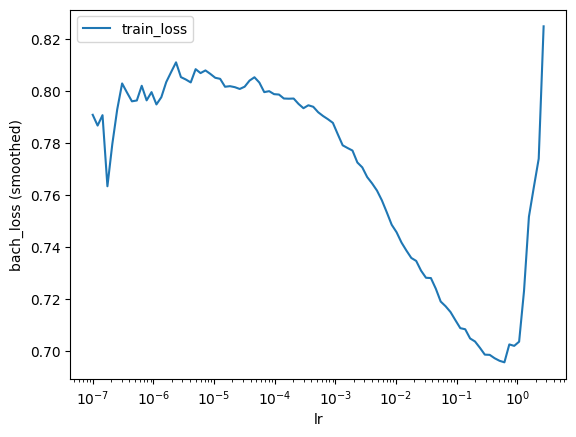

0:	[3s / 3s],		train_loss: 0.4228,	val_loss: 0.3214
1:	[3s / 6s],		train_loss: 0.2772,	val_loss: 0.2592
2:	[3s / 9s],		train_loss: 0.2520,	val_loss: 0.2785
3:	[3s / 12s],		train_loss: 0.2426,	val_loss: 0.2326
4:	[3s / 15s],		train_loss: 0.2352,	val_loss: 0.2394
5:	[3s / 19s],		train_loss: 0.2276,	val_loss: 0.2329
6:	[3s / 22s],		train_loss: 0.2280,	val_loss: 0.2199
7:	[3s / 25s],		train_loss: 0.2245,	val_loss: 0.2240
8:	[3s / 28s],		train_loss: 0.2204,	val_loss: 0.2064
9:	[3s / 31s],		train_loss: 0.2175,	val_loss: 0.2216
10:	[3s / 34s],		train_loss: 0.2170,	val_loss: 0.2287
11:	[2s / 37s],		train_loss: 0.2138,	val_loss: 0.2470
12:	[2s / 40s],		train_loss: 0.2149,	val_loss: 0.2210
13:	[2s / 43s],		train_loss: 0.2131,	val_loss: 0.2199
14:	[3s / 46s],		train_loss: 0.2089,	val_loss: 0.2369
15:	[3s / 49s],		train_loss: 0.2060,	val_loss: 0.2378
16:	[3s / 53s],		train_loss: 0.2116,	val_loss: 0.2133
17:	[3s / 56s],		train_loss: 0.2074,	val_loss: 0.2272
18:	[3s / 59s],		train_loss: 0.2065,	val_

/usr/local/lib/python3.10/dist-packages/torchtuples/base.py:669: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.net.load_state_dict(torch.load(path, **kwargs))


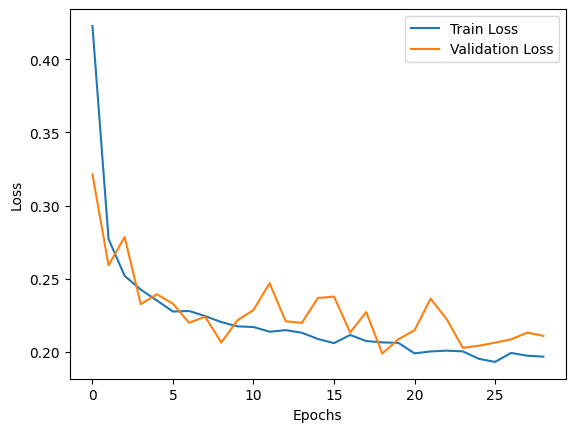

[✓] Saved fold results to tta_framewise_csvs/fold_1.csv

=== Final Aggregated Evaluation ===

📊 Final Aggregated Evaluation Metrics (Fold 1):
C-index: 0.9576
IBS:     0.0344
NBLL:    0.1209
Random C-index: 0.5066
Random IBS:     7.6485
Random NBLL:    1.2553
=== Evaluating on Fold 2 ===


/usr/local/lib/python3.10/dist-packages/torchtuples/base.py:669: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.net.load_state_dict(torch.load(path, **kwargs))


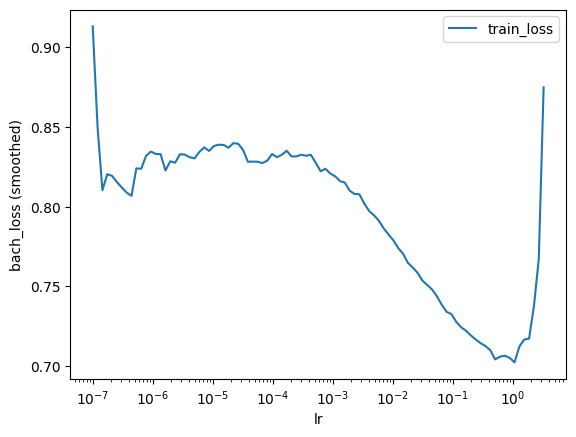

0:	[3s / 3s],		train_loss: 0.4283,	val_loss: 0.2952
1:	[3s / 6s],		train_loss: 0.2703,	val_loss: 0.2339
2:	[3s / 9s],		train_loss: 0.2418,	val_loss: 0.2239
3:	[2s / 12s],		train_loss: 0.2300,	val_loss: 0.2103
4:	[2s / 15s],		train_loss: 0.2245,	val_loss: 0.2024
5:	[3s / 18s],		train_loss: 0.2249,	val_loss: 0.2022
6:	[3s / 21s],		train_loss: 0.2216,	val_loss: 0.1960
7:	[2s / 24s],		train_loss: 0.2152,	val_loss: 0.2086
8:	[2s / 27s],		train_loss: 0.2121,	val_loss: 0.1987
9:	[2s / 30s],		train_loss: 0.2109,	val_loss: 0.1935
10:	[3s / 33s],		train_loss: 0.2053,	val_loss: 0.2008
11:	[3s / 36s],		train_loss: 0.2087,	val_loss: 0.1920
12:	[2s / 39s],		train_loss: 0.2048,	val_loss: 0.1972
13:	[2s / 42s],		train_loss: 0.2021,	val_loss: 0.1917
14:	[3s / 45s],		train_loss: 0.2022,	val_loss: 0.2011
15:	[3s / 48s],		train_loss: 0.2026,	val_loss: 0.1905
16:	[3s / 52s],		train_loss: 0.1967,	val_loss: 0.1885
17:	[3s / 55s],		train_loss: 0.2013,	val_loss: 0.1904
18:	[3s / 58s],		train_loss: 0.1996,	val_

/usr/local/lib/python3.10/dist-packages/torchtuples/base.py:669: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.net.load_state_dict(torch.load(path, **kwargs))


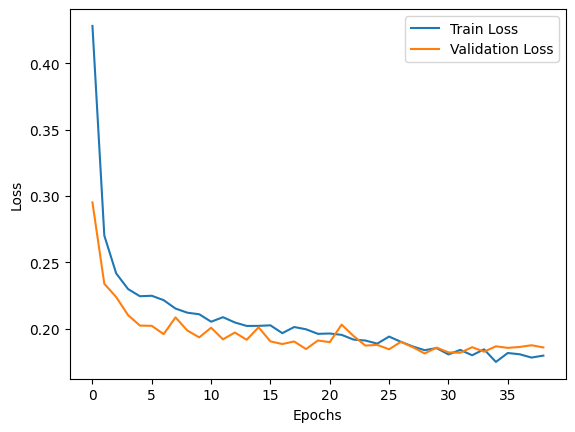

[✓] Saved fold results to tta_framewise_csvs/fold_2.csv

=== Final Aggregated Evaluation ===

📊 Final Aggregated Evaluation Metrics (Fold 2):
C-index: 0.9480
IBS:     0.0412
NBLL:    0.1590
Random C-index: 0.5253
Random IBS:     7.7044
Random NBLL:    1.2553
=== Evaluating on Fold 3 ===


/usr/local/lib/python3.10/dist-packages/torchtuples/base.py:669: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.net.load_state_dict(torch.load(path, **kwargs))


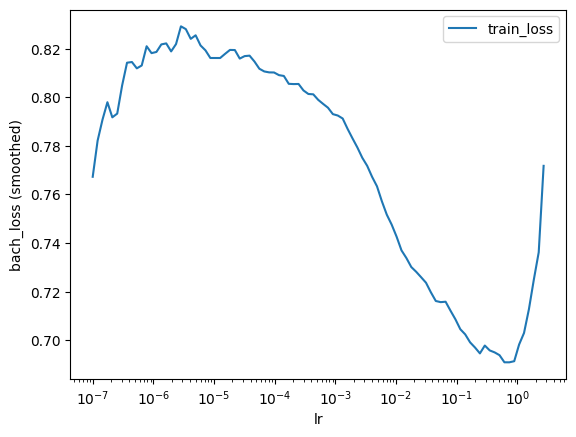

0:	[2s / 2s],		train_loss: 0.4249,	val_loss: 0.3287
1:	[3s / 6s],		train_loss: 0.2651,	val_loss: 0.2568
2:	[3s / 9s],		train_loss: 0.2413,	val_loss: 0.2278
3:	[3s / 12s],		train_loss: 0.2266,	val_loss: 0.2312
4:	[3s / 15s],		train_loss: 0.2263,	val_loss: 0.2208
5:	[3s / 18s],		train_loss: 0.2253,	val_loss: 0.2300
6:	[3s / 21s],		train_loss: 0.2205,	val_loss: 0.2691
7:	[3s / 24s],		train_loss: 0.2228,	val_loss: 0.2754
8:	[3s / 27s],		train_loss: 0.2142,	val_loss: 0.2130
9:	[3s / 30s],		train_loss: 0.2091,	val_loss: 0.2209
10:	[3s / 33s],		train_loss: 0.2103,	val_loss: 0.2135
11:	[3s / 37s],		train_loss: 0.2056,	val_loss: 0.2110
12:	[3s / 40s],		train_loss: 0.2079,	val_loss: 0.2375
13:	[3s / 43s],		train_loss: 0.2075,	val_loss: 0.2125
14:	[3s / 46s],		train_loss: 0.2044,	val_loss: 0.2652
15:	[3s / 49s],		train_loss: 0.2049,	val_loss: 0.2211
16:	[3s / 52s],		train_loss: 0.1975,	val_loss: 0.2266
17:	[3s / 56s],		train_loss: 0.2036,	val_loss: 0.2130
18:	[3s / 59s],		train_loss: 0.1981,	val_

/usr/local/lib/python3.10/dist-packages/torchtuples/base.py:669: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.net.load_state_dict(torch.load(path, **kwargs))


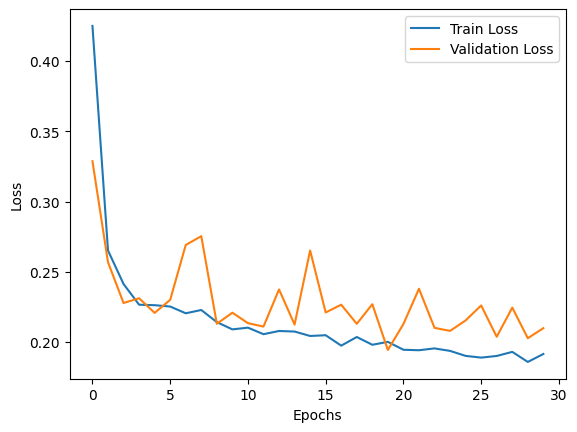

[✓] Saved fold results to tta_framewise_csvs/fold_3.csv

=== Final Aggregated Evaluation ===

📊 Final Aggregated Evaluation Metrics (Fold 3):
C-index: 0.9559
IBS:     0.0357
NBLL:    0.1347
Random C-index: 0.4908
Random IBS:     7.4264
Random NBLL:    1.2527
=== Evaluating on Fold 4 ===


/usr/local/lib/python3.10/dist-packages/torchtuples/base.py:669: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.net.load_state_dict(torch.load(path, **kwargs))


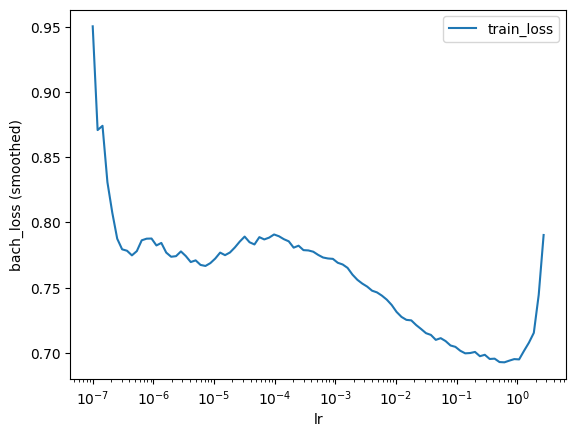

0:	[3s / 3s],		train_loss: 0.4283,	val_loss: 0.2840
1:	[3s / 6s],		train_loss: 0.2649,	val_loss: 0.2270
2:	[2s / 9s],		train_loss: 0.2376,	val_loss: 0.2118
3:	[2s / 11s],		train_loss: 0.2322,	val_loss: 0.2154
4:	[3s / 15s],		train_loss: 0.2310,	val_loss: 0.2113
5:	[2s / 18s],		train_loss: 0.2154,	val_loss: 0.1984
6:	[2s / 21s],		train_loss: 0.2156,	val_loss: 0.2023
7:	[3s / 24s],		train_loss: 0.2143,	val_loss: 0.1996
8:	[2s / 26s],		train_loss: 0.2135,	val_loss: 0.1986
9:	[3s / 30s],		train_loss: 0.2093,	val_loss: 0.1942
10:	[3s / 33s],		train_loss: 0.2085,	val_loss: 0.1904
11:	[3s / 36s],		train_loss: 0.2028,	val_loss: 0.1897
12:	[3s / 39s],		train_loss: 0.2009,	val_loss: 0.1896
13:	[3s / 42s],		train_loss: 0.2038,	val_loss: 0.1940
14:	[2s / 45s],		train_loss: 0.1994,	val_loss: 0.1952
15:	[2s / 48s],		train_loss: 0.2017,	val_loss: 0.2244
16:	[2s / 51s],		train_loss: 0.1973,	val_loss: 0.1890
17:	[3s / 54s],		train_loss: 0.1940,	val_loss: 0.1874
18:	[3s / 57s],		train_loss: 0.1941,	val_

/usr/local/lib/python3.10/dist-packages/torchtuples/base.py:669: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.net.load_state_dict(torch.load(path, **kwargs))


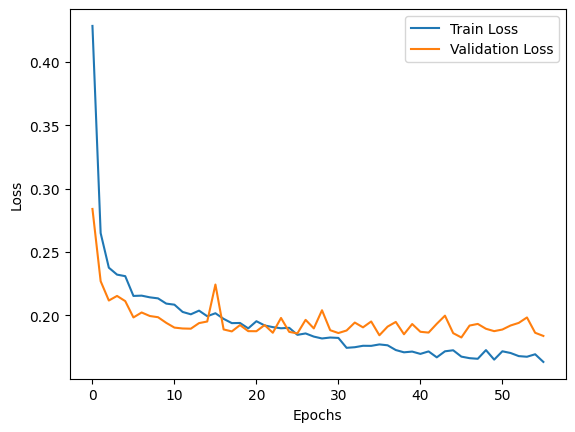

[✓] Saved fold results to tta_framewise_csvs/fold_4.csv

=== Final Aggregated Evaluation ===

📊 Final Aggregated Evaluation Metrics (Fold 4):
C-index: 0.9495
IBS:     0.0327
NBLL:    0.1119
Random C-index: 0.5391
Random IBS:     7.9707
Random NBLL:    1.2540
=== Evaluating on Fold 5 ===


/usr/local/lib/python3.10/dist-packages/torchtuples/base.py:669: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.net.load_state_dict(torch.load(path, **kwargs))


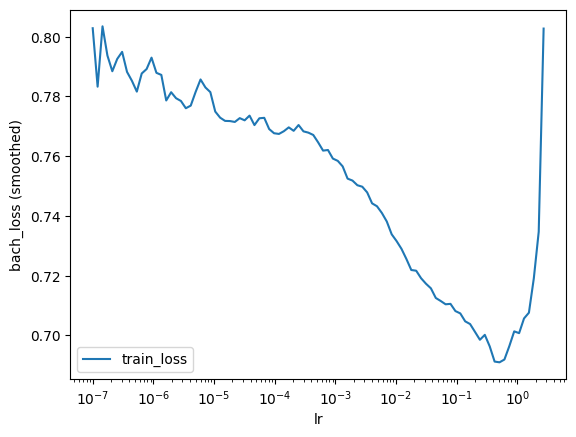

0:	[3s / 3s],		train_loss: 0.4277,	val_loss: 0.3354
1:	[3s / 6s],		train_loss: 0.2634,	val_loss: 0.2560
2:	[3s / 10s],		train_loss: 0.2395,	val_loss: 0.2510
3:	[3s / 13s],		train_loss: 0.2259,	val_loss: 0.2491
4:	[3s / 16s],		train_loss: 0.2210,	val_loss: 0.2585
5:	[3s / 20s],		train_loss: 0.2143,	val_loss: 0.2365
6:	[3s / 23s],		train_loss: 0.2097,	val_loss: 0.2346
7:	[3s / 26s],		train_loss: 0.2135,	val_loss: 0.2451
8:	[3s / 29s],		train_loss: 0.2052,	val_loss: 0.2397
9:	[3s / 32s],		train_loss: 0.2032,	val_loss: 0.2388
10:	[3s / 35s],		train_loss: 0.2026,	val_loss: 0.2466
11:	[3s / 39s],		train_loss: 0.1956,	val_loss: 0.2415
12:	[3s / 42s],		train_loss: 0.2002,	val_loss: 0.2457
13:	[3s / 45s],		train_loss: 0.1944,	val_loss: 0.2352
14:	[3s / 48s],		train_loss: 0.1955,	val_loss: 0.2398
15:	[3s / 52s],		train_loss: 0.1950,	val_loss: 0.2299
16:	[3s / 55s],		train_loss: 0.1954,	val_loss: 0.2336
17:	[3s / 58s],		train_loss: 0.1908,	val_loss: 0.2377
18:	[3s / 1m:1s],		train_loss: 0.1942,	v

/usr/local/lib/python3.10/dist-packages/torchtuples/base.py:669: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.net.load_state_dict(torch.load(path, **kwargs))


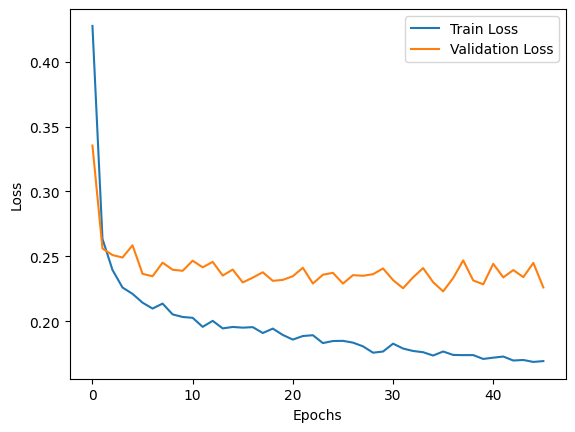

[✓] Saved fold results to tta_framewise_csvs/fold_5.csv

=== Final Aggregated Evaluation ===

📊 Final Aggregated Evaluation Metrics (Fold 5):
C-index: 0.9559
IBS:     0.0368
NBLL:    0.1401
Random C-index: 0.4966
Random IBS:     7.3031
Random NBLL:    1.2540
✅ Fold-wise metrics saved to 'fold_evaluation_metrics.csv'
✅ Average metrics saved to 'average_evaluation_metrics.csv'


In [11]:
output_dir = "tta_framewise_csvs"
survival_curves = "survival_curves"
os.makedirs(output_dir, exist_ok=True)
os.makedirs(survival_curves, exist_ok=True)
def process_and_collect_all_frames():
    all_true_times_folds, all_predicted_threshold_folds, all_predicted_ettc_folds = [], [], []
    for fold_id in range(1, 6):
        print(f"=== Evaluating on Fold {fold_id} ===")

        all_X_train, all_X_val, all_y_train, all_y_val, test_data = [], [], [], [], []
        c_indices, ibs_scores, nbll_scores = [], [], []
        c_indices_random, ibs_scores_random, nbll_scores_random = [], [], []
        all_true_times, all_predicted_threshold, all_predicted_ettc = [], [], []
        
        fold_metrics = []


        fold_results = []  

        for frame_id in range(1, 51):  
            df_train, df_val, df_test = load_frame_data(fold_id, frame_id)

            
            if df_train is None:
                continue  

            X_train, y_train, X_val, y_val, X_test, y_test = preprocess_data(df_train, df_val, df_test)

            
            all_X_train.append(X_train)
            all_X_val.append(X_val)
            all_y_train.append(y_train)
            all_y_val.append(y_val)
            test_data.append((frame_id, X_test, y_test))

        
        X_train_all = np.concatenate(all_X_train)
        y_train_all = (np.concatenate([y[0] for y in all_y_train]), np.concatenate([y[1] for y in all_y_train]))

        X_val_all = np.concatenate(all_X_val)
        y_val_all = (np.concatenate([y[0] for y in all_y_val]), np.concatenate([y[1] for y in all_y_val]))

        model, labtrans = train_model(X_train_all, y_train_all, X_val_all, y_val_all)


        for frame_id, X_test, y_test in test_data:
            
            surv, c_index, ibs, nbll = evaluate_model(model, labtrans, X_test, y_test)
            c_index_random, ibs_random, nbll_random = evaluate_random_times(y_test)

            c_indices.append(c_index)
            ibs_scores.append(ibs)
            nbll_scores.append(nbll)
            c_indices_random.append(c_index_random)
            ibs_scores_random.append(ibs_random)
            nbll_scores_random.append(nbll_random)

            true_times_test = y_test[0].numpy()
            predicted_times_optimal = compute_predicted_times(surv, 0.5)
            predicted_times_ettc = compute_ettc(surv)


            correlation = np.corrcoef(true_times_test, predicted_times_ettc)[0, 1]

            for t, pt_thresh, pt_ettc in zip(true_times_test, predicted_times_optimal, predicted_times_ettc):
                fold_results.append({
                    'Frame_ID': frame_id,
                    'True_Time': t,
                    'Predicted_TTC_Threshold': pt_thresh,
                    'Predicted_ETTC': pt_ettc
                })

            all_true_times.extend(true_times_test)
            all_predicted_threshold.extend(predicted_times_optimal)
            all_predicted_ettc.extend(predicted_times_ettc)

        df_fold = pd.DataFrame(fold_results)
        fold_csv_path = os.path.join(output_dir, f'fold_{fold_id}.csv')
        df_fold.to_csv(fold_csv_path, index=False)
        print(f"[✓] Saved fold results to {fold_csv_path}")
        # Aggregate all fold predictions into global lists
        all_true_times_folds.extend(all_true_times)
        all_predicted_threshold_folds.extend(all_predicted_threshold)
        all_predicted_ettc_folds.extend(all_predicted_ettc)

        print("\n=== Final Aggregated Evaluation ===")
        if c_indices:
            mean_c_index = np.mean(c_indices)
            mean_ibs = np.mean(ibs_scores)
            mean_nbll = np.mean(nbll_scores)
        
            mean_c_index_random = np.mean(c_indices_random)
            mean_ibs_random = np.mean(ibs_scores_random)
            mean_nbll_random = np.mean(nbll_scores_random)
        
            print(f"\n📊 Final Aggregated Evaluation Metrics (Fold {fold_id}):")
            print(f"C-index: {mean_c_index:.4f}")
            print(f"IBS:     {mean_ibs:.4f}")
            print(f"NBLL:    {mean_nbll:.4f}")
            print(f"Random C-index: {mean_c_index_random:.4f}")
            print(f"Random IBS:     {mean_ibs_random:.4f}")
            print(f"Random NBLL:    {mean_nbll_random:.4f}")
        
            fold_metrics.append({
                'fold': fold_id,
                'c_index': mean_c_index,
                'ibs': mean_ibs,
                'nbll': mean_nbll,
                'c_index_random': mean_c_index_random,
                'ibs_random': mean_ibs_random,
                'nbll_random': mean_nbll_random
            })
        else:
            print("No valid frames for this fold.")

    metrics_df = pd.DataFrame(fold_metrics)
    metrics_df.to_csv("fold_evaluation_metrics.csv", index=False)

    avg_metrics = metrics_df.mean(numeric_only=True)
    avg_metrics_df = pd.DataFrame([avg_metrics])
    avg_metrics_df.to_csv("average_evaluation_metrics.csv", index=False)

    print("✅ Fold-wise metrics saved to 'fold_evaluation_metrics.csv'")
    print("✅ Average metrics saved to 'average_evaluation_metrics.csv'")
    
    return (np.array(all_true_times_folds),
            np.array(all_predicted_threshold_folds),
            np.array(all_predicted_ettc_folds))

true_all, pred_thresh_all, pred_ettc_all = process_and_collect_all_frames()
true_times = np.array(true_all)  

# plot_combined_scatter(true_all, pred_thresh_all, pred_ettc_all)

In [12]:
np.random.seed(1234)
_ = torch.manual_seed(123)
random_preds = np.random.uniform(low=true_times.min(), high=true_times.max(), size=true_times.shape)

In [13]:
comparison_df = pd.DataFrame({
    'True_Time': true_all,
    'Pred_Threshold': pred_thresh_all,
    'Pred_ETTC': pred_ettc_all,
    'Random_Pred': random_preds
})

# Print full DataFrame
# print(comparison_df.to_string(index=False))
# Save DataFrame as CSV
comparison_df.to_csv("comparison_results.csv", index=False)
print("CSV file saved successfully.")

CSV file saved successfully.


In [14]:
import pandas as pd

# Load the CSV file
file_path = "comparison_results.csv"  # Replace with your actual file path
try:
    df = pd.read_csv(file_path)
    
    # Calculate the correlation matrix
    correlation_matrix = df[['True_Time', 'Pred_Threshold', 'Pred_ETTC', 'Random_Pred']].corr()
    
    # Print the correlation matrix
    print("\nCorrelation Coefficients:")
    print(correlation_matrix)
    
    # Save the correlation matrix to a CSV file
    correlation_matrix.to_csv("correlation_matrix.csv", index=True)
    print("\nCorrelation matrix saved as 'correlation_matrix.csv'.")
    
except FileNotFoundError:
    print(f"Error: File '{file_path}' not found. Please check the file path and try again.")



Correlation Coefficients:
                True_Time  Pred_Threshold  Pred_ETTC  Random_Pred
True_Time        1.000000        0.966448   0.968412    -0.008052
Pred_Threshold   0.966448        1.000000   0.999078    -0.009448
Pred_ETTC        0.968412        0.999078   1.000000    -0.009356
Random_Pred     -0.008052       -0.009448  -0.009356     1.000000

Correlation matrix saved as 'correlation_matrix.csv'.
